# Airline Passenger Satisfaction Analysis

End-to-end ML study: EDA → Binary & Multinomial Logistic Regression → LDA / QDA → Naïve Bayes → Regression Models.

## 1. Setup & Data Loading

In [10]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (
    classification_report, roc_curve, auc, roc_auc_score, mean_squared_error
)

sns.set_theme(style="whitegrid")

df_train = pd.read_csv('./dataset/train.csv')
df_test  = pd.read_csv('./dataset/test.csv')
display(df_train.head())

,Unnamed: 0,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,0,70172,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,...,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,1,5047,Male,disloyal Customer,25,Business travel,Business,235,3,2,...,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied
2,2,110028,Female,Loyal Customer,26,Business travel,Business,1142,2,2,...,5,4,3,4,4,4,5,0,0.0,satisfied
3,3,24026,Female,Loyal Customer,25,Business travel,Business,562,2,5,...,2,2,5,3,1,4,2,11,9.0,neutral or dissatisfied
4,4,119299,Male,Loyal Customer,61,Business travel,Business,214,3,3,...,3,3,4,4,3,3,3,0,0.0,satisfied


## 2. Data Preprocessing

In [11]:
columns_to_drop = ['Unnamed: 0', 'id']
df_train = df_train.drop(columns=[col for col in columns_to_drop if col in df_train.columns])
df_test  = df_test.drop(columns=[col for col in columns_to_drop if col in df_test.columns])

print("Train Dataset Info:")
display(df_train.info())

print("\nMissing Values (Train):")
display(df_train.isnull().sum()[df_train.isnull().sum() > 0])

# Median imputation — fit on train, apply to both to prevent data leakage
delay_median = df_train['Arrival Delay in Minutes'].median()
df_train['Arrival Delay in Minutes'] = df_train['Arrival Delay in Minutes'].fillna(delay_median)
df_test['Arrival Delay in Minutes']  = df_test['Arrival Delay in Minutes'].fillna(delay_median)

Train Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103904 entries, 0 to 103903
Data columns (total 23 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Gender                             103904 non-null  object 
 1   Customer Type                      103904 non-null  object 
 2   Age                                103904 non-null  int64  
 3   Type of Travel                     103904 non-null  object 
 4   Class                              103904 non-null  object 
 5   Flight Distance                    103904 non-null  int64  
 6   Inflight wifi service              103904 non-null  int64  
 7   Departure/Arrival time convenient  103904 non-null  int64  
 8   Ease of Online booking             103904 non-null  int64  
 9   Gate location                      103904 non-null  int64  
 10  Food and drink                     103904 non-null  int64  
 11  Online boarding    

None


Missing Values (Train):


Arrival Delay in Minutes    310
dtype: int64

## 3. Exploratory Data Analysis

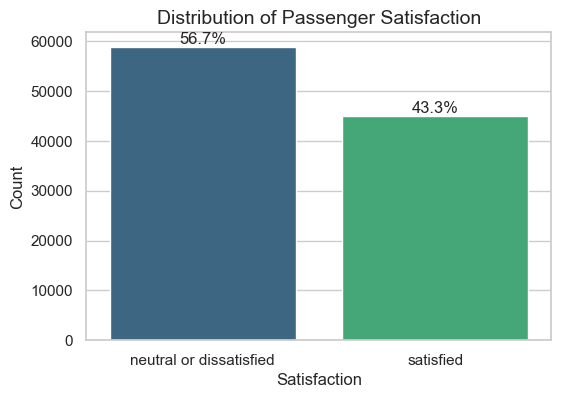

In [12]:
plt.figure(figsize=(6, 4))
ax = sns.countplot(data=df_train, x='satisfaction', palette='viridis')
plt.title('Distribution of Passenger Satisfaction', fontsize=14)
plt.xlabel('Satisfaction')
plt.ylabel('Count')

total = len(df_train)
for p in ax.patches:
    percentage = f'{100 * p.get_height() / total:.1f}%'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='bottom')

plt.show()

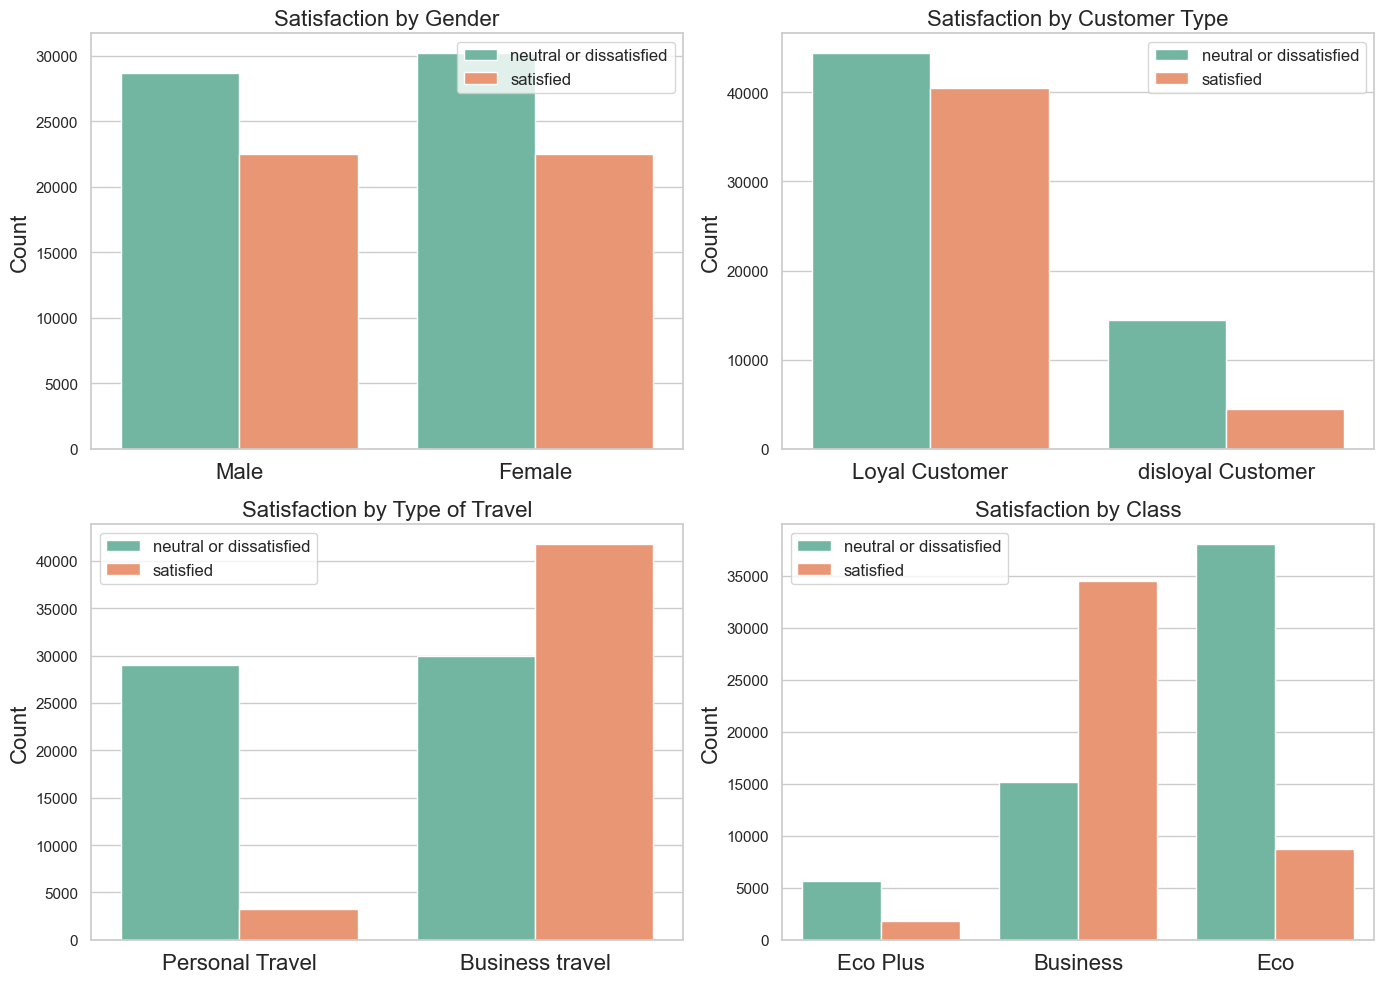

In [13]:
categorical_cols = ['Gender', 'Customer Type', 'Type of Travel', 'Class']

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, col in enumerate(categorical_cols):
    sns.countplot(data=df_train, x=col, hue='satisfaction', palette='Set2', ax=axes[i])
    axes[i].set_title(f'Satisfaction by {col}', fontsize=16)
    axes[i].set_xlabel('')
    axes[i].set_xticklabels(axes[i].get_xticklabels(), fontsize=16)
    axes[i].set_ylabel('Count', fontsize=16)
    axes[i].legend(fontsize=12)

plt.tight_layout()
plt.show()

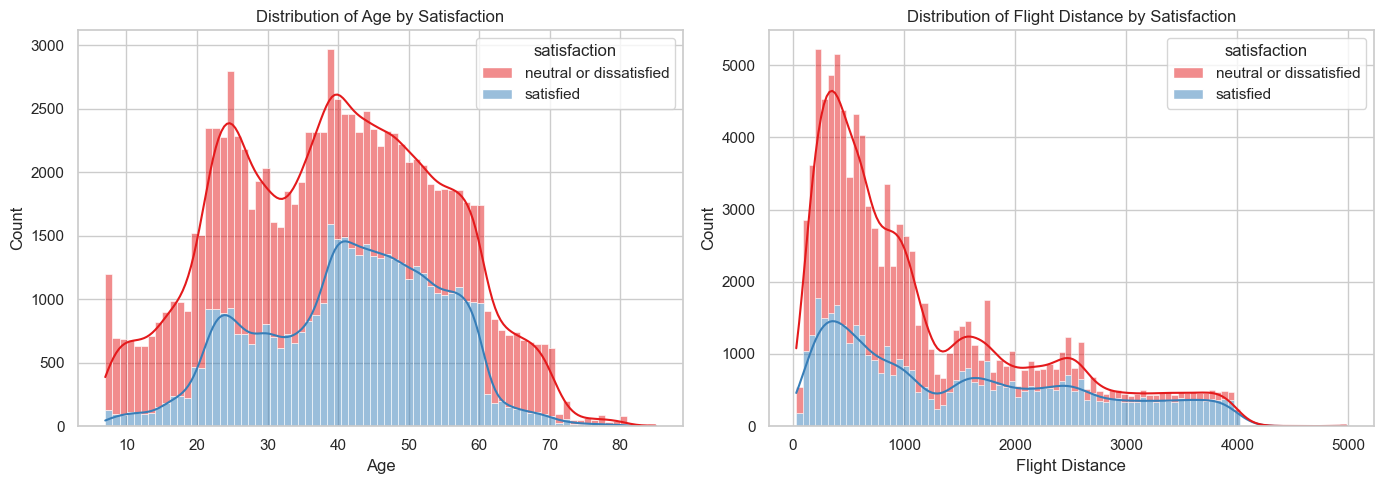

In [14]:
continuous_cols = ['Age', 'Flight Distance']

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for i, col in enumerate(continuous_cols):
    sns.histplot(data=df_train, x=col, hue='satisfaction', multiple='stack',
                 palette='Set1', kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {col} by Satisfaction', fontsize=12)

plt.tight_layout()
plt.show()

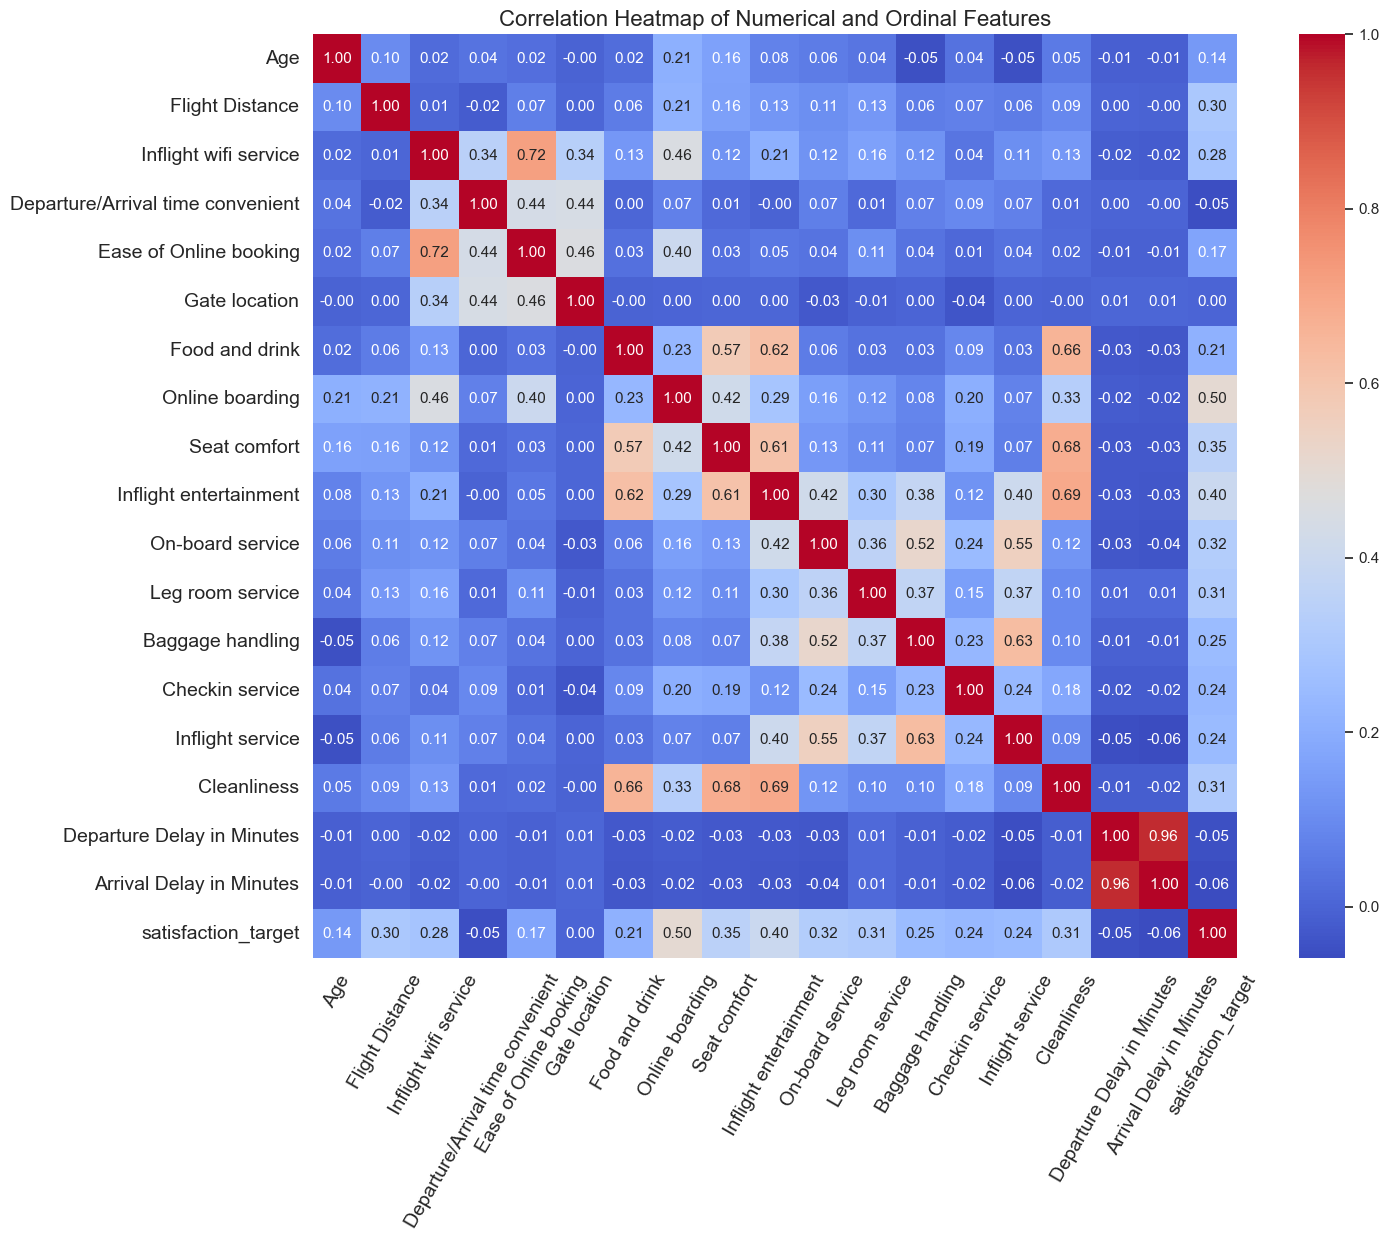

In [15]:
numeric_df = df_train.select_dtypes(include=[np.number])

# Temporarily encode target for inclusion in the correlation matrix
numeric_df['satisfaction_target'] = df_train['satisfaction'].map({'satisfied': 1, 'neutral or dissatisfied': 0})

plt.figure(figsize=(16, 12))
corr_matrix = numeric_df.corr()

sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, annot_kws={"size": 11})

plt.title('Correlation Heatmap of Numerical and Ordinal Features', fontsize=16)
plt.xticks(rotation=60, fontsize=14)
plt.yticks(fontsize=14)
plt.show()

## 4. Binary Logistic Regression (statsmodels)

Predict passenger satisfaction (binary: satisfied vs. neutral/dissatisfied).

In [16]:
df_lr_train = df_train.copy()
df_lr_test  = df_test.copy()

le = LabelEncoder()
df_lr_train['satisfaction'] = le.fit_transform(df_lr_train['satisfaction'])
df_lr_test['satisfaction']  = le.transform(df_lr_test['satisfaction'])

cat_cols = ['Gender', 'Customer Type', 'Type of Travel', 'Class']
df_lr_train = pd.get_dummies(df_lr_train, columns=cat_cols, drop_first=True)
df_lr_test  = pd.get_dummies(df_lr_test,  columns=cat_cols, drop_first=True)
df_lr_test  = df_lr_test.reindex(columns=df_lr_train.columns, fill_value=0)

X_tr = df_lr_train.drop('satisfaction', axis=1)
y_tr = df_lr_train['satisfaction']
X_te = df_lr_test.drop('satisfaction', axis=1)
y_te = df_lr_test['satisfaction']

# Standardize features for comparable coefficient magnitudes — fit on train only
scaler = StandardScaler()
X_tr_scaled = pd.DataFrame(scaler.fit_transform(X_tr), columns=X_tr.columns)
X_te_scaled = pd.DataFrame(scaler.transform(X_te),     columns=X_te.columns)

# Add intercept term (required by statsmodels)
X_scaled    = sm.add_constant(X_tr_scaled)
y           = y_tr

In [17]:
logit_model = sm.Logit(y, X_scaled)
result = logit_model.fit()

print(result.summary())

Optimization terminated successfully.
         Current function value: 0.333884
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:           satisfaction   No. Observations:               103904
Model:                          Logit   Df Residuals:                   103880
Method:                           MLE   Df Model:                           23
Date:                Tue, 24 Feb 2026   Pseudo R-squ.:                  0.5120
Time:                        11:58:19   Log-Likelihood:                -34692.
converged:                       True   LL-Null:                       -71094.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const                                -0.5082      0.010    -49

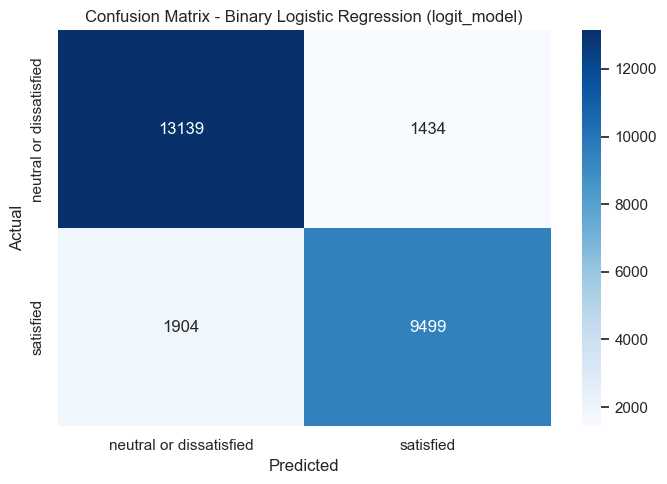

In [18]:
# Confusion matrix for statsmodels logit_model on test data
X_te_const = sm.add_constant(X_te_scaled, has_constant='add')
y_prob_logit = result.predict(X_te_const)
y_pred_logit = (y_prob_logit >= 0.5).astype(int)

label_map = {0: 'neutral or dissatisfied', 1: 'satisfied'}
cm = pd.crosstab(
    y_te.map(label_map),
    pd.Series(y_pred_logit, index=y_te.index).map(label_map),
    rownames=['Actual'],
    colnames=['Predicted']
)

plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Binary Logistic Regression (logit_model)')
plt.tight_layout()
plt.show()

In [20]:
# Accuracy of statsmodels binary logistic regression (logit_model) on test set
X_te_const = sm.add_constant(X_te_scaled, has_constant='add')
y_prob_logit = result.predict(X_te_const)
y_pred_logit = (y_prob_logit >= 0.5).astype(int)

accuracy_logit = (y_pred_logit == y_te).mean()
print(f"Logit model accuracy: {accuracy_logit:.4f}")

Logit model accuracy: 0.8715


### Binary Logistic Regression without confounding (statsmodels)

In [27]:
X_scaled.columns

Index(['const', 'Age', 'Flight Distance', 'Inflight wifi service',
       'Departure/Arrival time convenient', 'Ease of Online booking',
       'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort',
       'Inflight entertainment', 'On-board service', 'Leg room service',
       'Baggage handling', 'Checkin service', 'Inflight service',
       'Cleanliness', 'Departure Delay in Minutes', 'Arrival Delay in Minutes',
       'Gender_Male', 'Customer Type_disloyal Customer',
       'Type of Travel_Personal Travel', 'Class_Eco', 'Class_Eco Plus'],
      dtype='object')

In [30]:
# Refit without 'Arrival Delay' to assess its confounding effect on other coefficients
X_scaled_no_confounder    = X_scaled.drop('Arrival Delay in Minutes', axis=1)
X_te_scaled_no_confounder = sm.add_constant(X_te_scaled).drop('Arrival Delay in Minutes', axis=1)

logit_model_corrected = sm.Logit(y, X_scaled_no_confounder)
result_corrected = logit_model_corrected.fit()

print("Model Summary after removing the confounding variable (Arrival Delay):")
print(result_corrected.summary())

Optimization terminated successfully.
         Current function value: 0.334337
         Iterations 7
Model Summary after removing the confounding variable (Arrival Delay):
                           Logit Regression Results                           
Dep. Variable:           satisfaction   No. Observations:               103904
Model:                          Logit   Df Residuals:                   103881
Method:                           MLE   Df Model:                           22
Date:                Tue, 24 Feb 2026   Pseudo R-squ.:                  0.5114
Time:                        12:05:13   Log-Likelihood:                -34739.
converged:                       True   LL-Null:                       -71094.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                        coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------

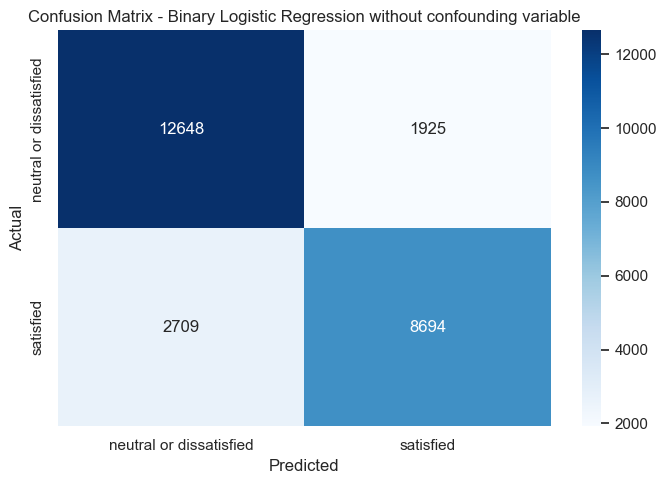

In [31]:
# Confusion matrix for statsmodels logit_model on test data
X_te_const = sm.add_constant(X_te_scaled_no_confounder, has_constant='add')
y_prob_logit = result.predict(X_te_const)
y_pred_logit = (y_prob_logit >= 0.5).astype(int)

label_map = {0: 'neutral or dissatisfied', 1: 'satisfied'}
cm = pd.crosstab(
    y_te.map(label_map),
    pd.Series(y_pred_logit, index=y_te.index).map(label_map),
    rownames=['Actual'],
    colnames=['Predicted']
)

plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Binary Logistic Regression without confounding variable')
plt.tight_layout()
plt.show()

In [33]:
# Accuracy of statsmodels binary logistic regression (logit_model) on test set
X_te_const = sm.add_constant(X_te_scaled_no_confounder, has_constant='add')
y_prob_logit = result.predict(X_te_const)
y_pred_logit = (y_prob_logit >= 0.5).astype(int)

accuracy_logit = (y_pred_logit == y_te).mean()
print(f"Logit model without confounding accuracy: {accuracy_logit:.4f}")

Logit model without confounding accuracy: 0.8216


## 5. Multinomial Logistic Regression

Predict travel class (Economy / Eco Plus / Business) from passenger and flight attributes. We do **not** use satisfaction as a feature, since satisfaction is surveyed after the flight and would not be available when predicting class (e.g. at booking).

In [46]:
# Predict Class from all other columns except satisfaction (post-flight outcome, not available at prediction time)
target_multi = 'Class'
feature_cols_multi = [c for c in df_train.columns if c not in (target_multi, 'satisfaction')]
cat_cols_multi = ['Gender', 'Customer Type', 'Type of Travel']

X_multi_train = df_train[feature_cols_multi].copy()
X_multi_test  = df_test[feature_cols_multi].copy()
X_multi_train = pd.get_dummies(X_multi_train, columns=cat_cols_multi, drop_first=True)
X_multi_test  = pd.get_dummies(X_multi_test,  columns=cat_cols_multi, drop_first=True)
X_multi_test  = X_multi_test.reindex(columns=X_multi_train.columns, fill_value=0)

y_multi_train = df_train['Class']
y_multi_test  = df_test['Class']

scaler_multi = StandardScaler()
X_multi_train_scaled = scaler_multi.fit_transform(X_multi_train)
X_multi_test_scaled  = scaler_multi.transform(X_multi_test)

multi_log_reg = LogisticRegression(
    multi_class='multinomial',
    solver='lbfgs',
    class_weight='balanced'
)
multi_log_reg.fit(X_multi_train_scaled, y_multi_train)

y_pred_multi = multi_log_reg.predict(X_multi_test_scaled)
print("Multinomial Logistic Regression Classification Report (Predicting 'Class'):\n")
print(classification_report(y_multi_test, y_pred_multi))

Multinomial Logistic Regression Classification Report (Predicting 'Class'):

              precision    recall  f1-score   support

    Business       0.88      0.79      0.83     12495
         Eco       0.78      0.73      0.75     11564
    Eco Plus       0.17      0.35      0.23      1917

    accuracy                           0.73     25976
   macro avg       0.61      0.62      0.60     25976
weighted avg       0.78      0.73      0.75     25976



Confusion Matrix - Multinomial Logistic Regression:


Predicted,Business,Eco,Eco Plus
Actual,,,
Business,9932,1271,1292
Eco,1167,8402,1995
Eco Plus,215,1039,663


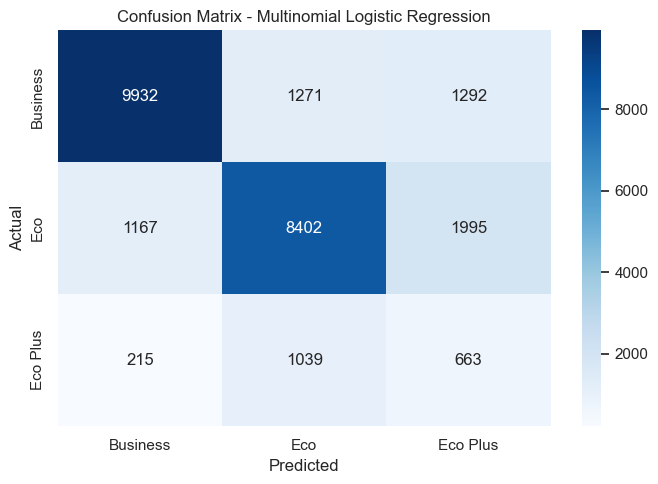

In [48]:
# Confusion matrix for multinomial logistic regression (predicting Class)
cm_multi = pd.crosstab(
    y_multi_test,
    pd.Series(y_pred_multi, index=y_multi_test.index),
    rownames=['Actual'],
    colnames=['Predicted']
)

print("Confusion Matrix - Multinomial Logistic Regression:")
display(cm_multi)

plt.figure(figsize=(7, 5))
sns.heatmap(cm_multi, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Multinomial Logistic Regression")
plt.tight_layout()
plt.show()

## 6. Linear & Quadratic Discriminant Analysis

In [49]:
X_train_bin = X_scaled_no_confounder
X_test_bin  = X_te_scaled_no_confounder
y_train_bin = y_tr
y_test_bin  = y_te

In [50]:
lda = LinearDiscriminantAnalysis()
lda.fit(X_train_bin, y_train_bin)

y_pred_lda_default = lda.predict(X_test_bin)

print("LDA Classification Report (Default Threshold = 0.5):\n")
print(classification_report(y_test_bin, y_pred_lda_default))

LDA Classification Report (Default Threshold = 0.5):

              precision    recall  f1-score   support

           0       0.87      0.90      0.88     14573
           1       0.86      0.83      0.85     11403

    accuracy                           0.87     25976
   macro avg       0.87      0.86      0.87     25976
weighted avg       0.87      0.87      0.87     25976



Confusion Matrix - LDA Default:


Predicted,0,1
Actual,,
0,13055,1518
1,1921,9482


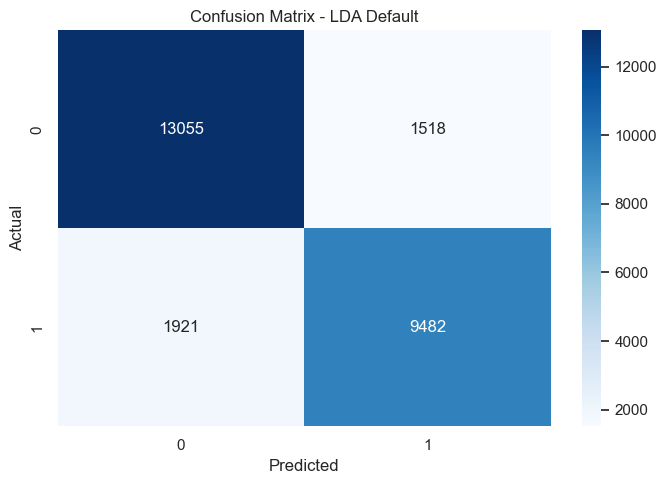

In [54]:
# Confusion matrix for multinomial logistic regression (predicting Class)
cm_multi = pd.crosstab(
    y_test_bin,
    pd.Series(y_pred_lda_default, index=y_test_bin.index),
    rownames=['Actual'],
    colnames=['Predicted']
)

print("Confusion Matrix - LDA Default:")
display(cm_multi)

plt.figure(figsize=(7, 5))
sns.heatmap(cm_multi, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - LDA Default")
plt.tight_layout()
plt.show()

Optimal Threshold (Youden's J): 0.5413

LDA Classification Report (Optimal Threshold):

              precision    recall  f1-score   support

           0       0.87      0.91      0.89     14573
           1       0.87      0.82      0.85     11403

    accuracy                           0.87     25976
   macro avg       0.87      0.86      0.87     25976
weighted avg       0.87      0.87      0.87     25976



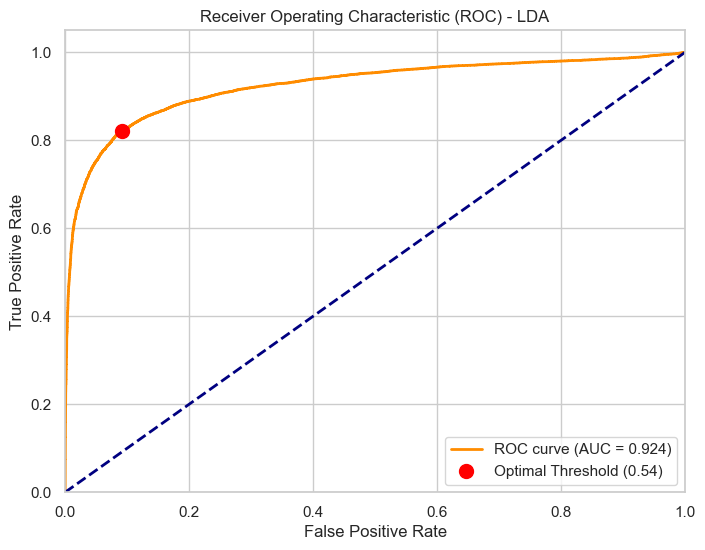

In [24]:
y_prob_lda = lda.predict_proba(X_test_bin)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test_bin, y_prob_lda)
roc_auc = auc(fpr, tpr)

# Optimal threshold via Youden's J statistic: maximizes (TPR - FPR)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

print(f"Optimal Threshold (Youden's J): {optimal_threshold:.4f}")

y_pred_lda_optimal = (y_prob_lda >= optimal_threshold).astype(int)

print("\nLDA Classification Report (Optimal Threshold):\n")
print(classification_report(y_test_bin, y_pred_lda_optimal))

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.scatter(fpr[optimal_idx], tpr[optimal_idx], marker='o', color='red', s=100,
            label=f'Optimal Threshold ({optimal_threshold:.2f})', zorder=5)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - LDA')
plt.legend(loc="lower right")
plt.show()

In [25]:
# reg_param regularizes covariance matrices to prevent singularity with correlated features
qda = QuadraticDiscriminantAnalysis(reg_param=0.0001)
qda.fit(X_train_bin, y_train_bin)

y_pred_qda = qda.predict(X_test_bin)

print("QDA Classification Report:\n")
print(classification_report(y_test_bin, y_pred_qda))

QDA Classification Report:

              precision    recall  f1-score   support

           0       0.85      0.89      0.87     14573
           1       0.85      0.80      0.83     11403

    accuracy                           0.85     25976
   macro avg       0.85      0.85      0.85     25976
weighted avg       0.85      0.85      0.85     25976



Confusion Matrix - QDA:


Predicted,0,1
Actual,,
0,12929,1644
1,2235,9168


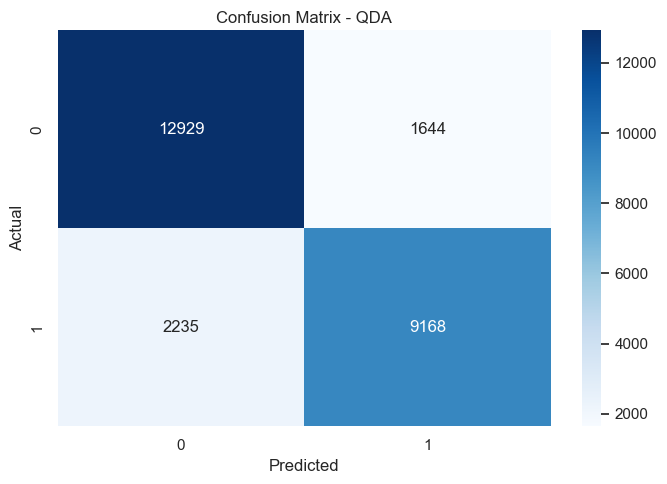

In [55]:
# Confusion matrix for multinomial logistic regression (predicting Class)
cm_multi = pd.crosstab(
    y_test_bin,
    pd.Series(y_pred_qda, index=y_test_bin.index),
    rownames=['Actual'],
    colnames=['Predicted']
)

print("Confusion Matrix - QDA:")
display(cm_multi)

plt.figure(figsize=(7, 5))
sns.heatmap(cm_multi, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - QDA")
plt.tight_layout()
plt.show()

## 7. Naïve Bayes

In [26]:
gnb = GaussianNB()
gnb.fit(X_train_bin, y_train_bin)

y_pred_gnb = gnb.predict(X_test_bin)
print("Gaussian Naïve Bayes Classification Report:\n")
print(classification_report(y_test_bin, y_pred_gnb))

Gaussian Naïve Bayes Classification Report:

              precision    recall  f1-score   support

           0       0.86      0.90      0.88     14573
           1       0.86      0.81      0.83     11403

    accuracy                           0.86     25976
   macro avg       0.86      0.85      0.86     25976
weighted avg       0.86      0.86      0.86     25976



Confusion Matrix - Gaussian Naive Bayes:


Predicted,0,1
Actual,,
0,13059,1514
1,2153,9250


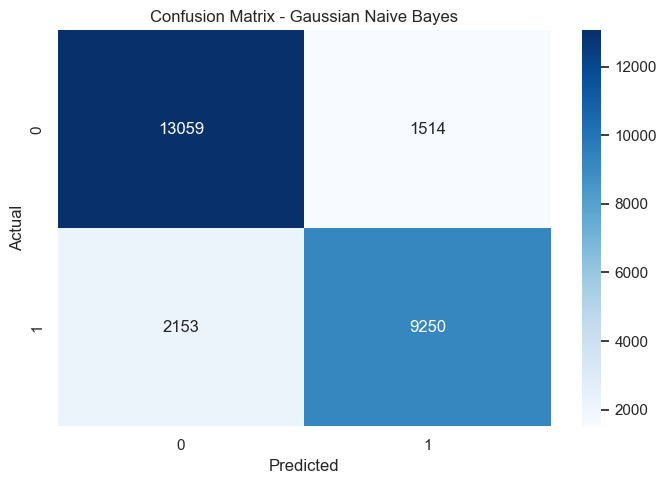

In [56]:
# Confusion matrix for multinomial logistic regression (predicting Class)
cm_multi = pd.crosstab(
    y_test_bin,
    pd.Series(y_pred_gnb, index=y_test_bin.index),
    rownames=['Actual'],
    colnames=['Predicted']
)

print("Confusion Matrix - Gaussian Naive Bayes:")
display(cm_multi)

plt.figure(figsize=(7, 5))
sns.heatmap(cm_multi, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Gaussian Naive Bayes")
plt.tight_layout()
plt.show()

## 8. Model Comparison: LR, LDA, QDA, Naïve Bayes

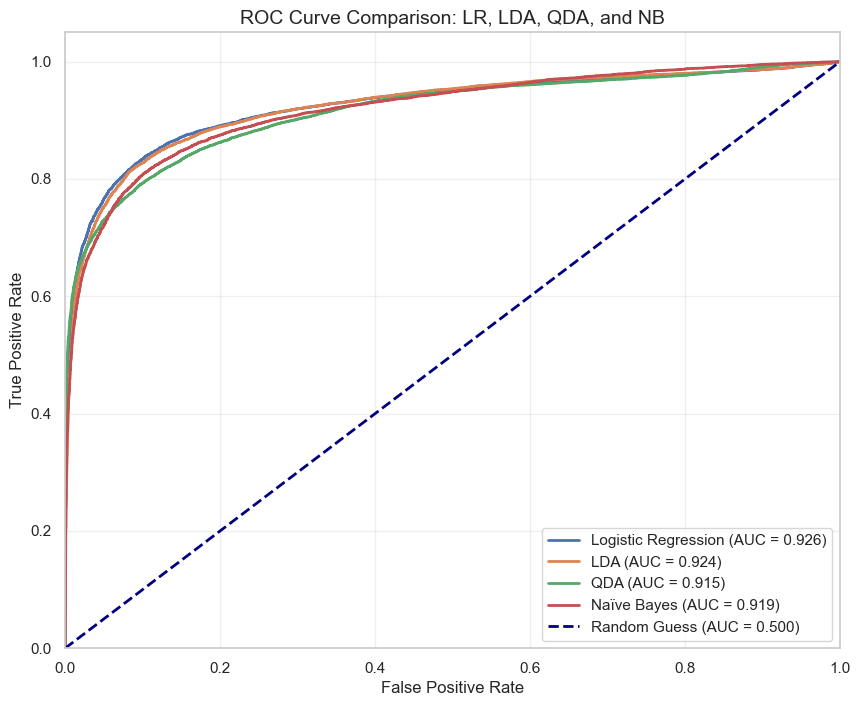

In [27]:
# sklearn LR is used here instead of the statsmodels model from Section 4,
# which was fit for inference and does not expose predict_proba().
lr_bin = LogisticRegression(solver='lbfgs')
lr_bin.fit(X_train_bin, y_train_bin)

models_probs = {
    'Logistic Regression': lr_bin.predict_proba(X_test_bin)[:, 1],
    'LDA': lda.predict_proba(X_test_bin)[:, 1],
    'QDA': qda.predict_proba(X_test_bin)[:, 1],
    'Naïve Bayes': gnb.predict_proba(X_test_bin)[:, 1]
}

plt.figure(figsize=(10, 8))

for model_name, y_prob in models_probs.items():
    fpr, tpr, _ = roc_curve(y_test_bin, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{model_name} (AUC = {roc_auc:.3f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess (AUC = 0.500)')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve Comparison: LR, LDA, QDA, and NB', fontsize=14)
plt.legend(loc="lower right", fontsize=11)
plt.grid(alpha=0.3)
plt.show()

## 9. Regression Models: Linear vs. Poisson

Predict **Arrival Delay in Minutes** (available after imputation in Section 2) using all available features: demographics, flight details, service ratings, and departure delay.

In [28]:
# Target: Arrival Delay in Minutes (imputed in Section 2).
target = 'Arrival Delay in Minutes'
feature_cols = [c for c in df_train.columns if c not in ('satisfaction', target)]
cat_cols_reg = ['Gender', 'Customer Type', 'Type of Travel', 'Class']

X_reg_train = df_train[feature_cols].copy()
X_reg_test  = df_test[feature_cols].copy()
X_reg_train = pd.get_dummies(X_reg_train, columns=cat_cols_reg, drop_first=True)
X_reg_test  = pd.get_dummies(X_reg_test,  columns=cat_cols_reg, drop_first=True)
X_reg_test  = X_reg_test.reindex(columns=X_reg_train.columns, fill_value=0)

y_reg_train = df_train[target]
y_reg_test  = df_test[target]

# Standardize features; critical for Poisson GLM convergence — fit on train only
scaler_reg = StandardScaler()
X_reg_train_scaled = pd.DataFrame(scaler_reg.fit_transform(X_reg_train), columns=X_reg_train.columns)
X_reg_test_scaled  = pd.DataFrame(scaler_reg.transform(X_reg_test),      columns=X_reg_train.columns)

# Add intercept term (required by statsmodels)
X_reg_train_scaled = sm.add_constant(X_reg_train_scaled)
X_reg_test_scaled  = sm.add_constant(X_reg_test_scaled)

# OLS
linear_model = sm.OLS(y_reg_train, X_reg_train_scaled).fit()
print("--- Linear Regression (OLS) Summary ---")
print(linear_model.summary().tables[1])

# Poisson GLM (delay in minutes is non-negative, count-like)
poisson_model = sm.GLM(y_reg_train, X_reg_train_scaled, family=sm.families.Poisson()).fit()
print("\n--- Poisson Regression Summary ---")
print(poisson_model.summary().tables[1])

--- Linear Regression (OLS) Summary ---
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const                                15.1334      0.033    452.404      0.000      15.068      15.199
Age                                  -0.0899      0.036     -2.494      0.013      -0.160      -0.019
Flight Distance                      -0.1447      0.039     -3.701      0.000      -0.221      -0.068
Inflight wifi service                -0.0451      0.052     -0.860      0.390      -0.148       0.058
Departure/Arrival time convenient    -0.0329      0.043     -0.761      0.446      -0.118       0.052
Ease of Online booking               -0.0060      0.055     -0.109      0.914      -0.114       0.102
Gate location                         0.0248      0.041      0.604      0.546      -0.056       0.105
Food and drink                       -0.16

--- Error Metrics (Test Set) ---
Linear Regression RMSE:  11.02 minutes
Poisson Regression RMSE: 55.44 minutes

--- Non-negativity (delays are ≥ 0) ---
Number of negative delay predictions (Linear):  236
Number of negative delay predictions (Poisson): 0


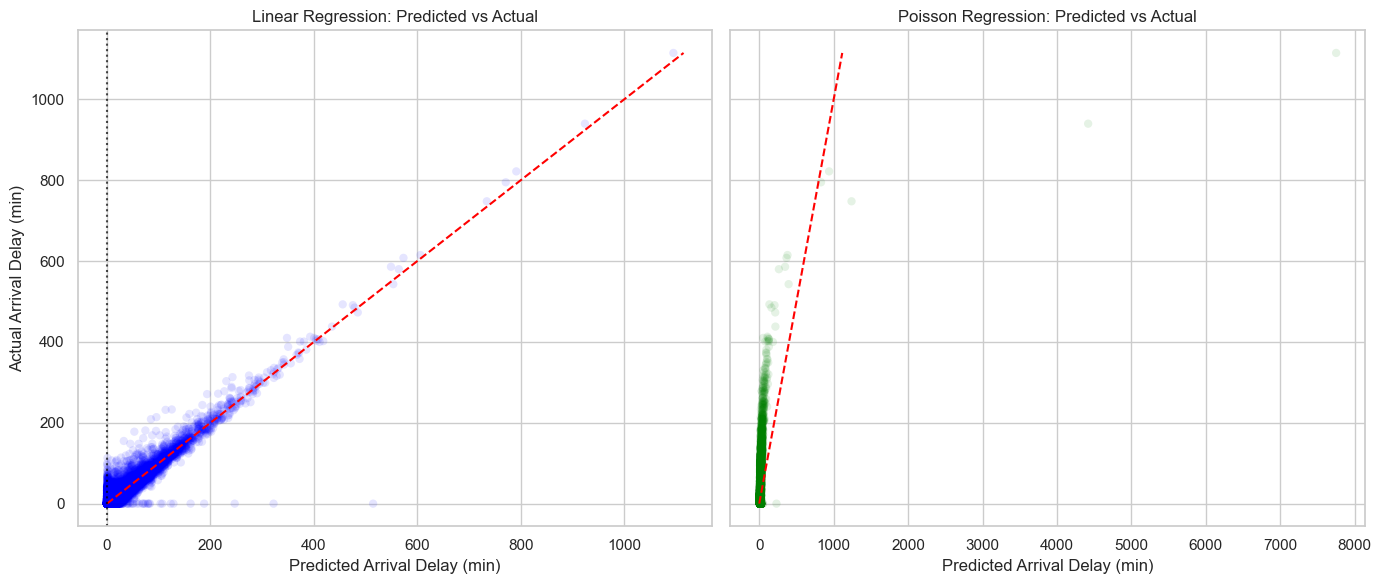

In [29]:
y_pred_linear  = linear_model.predict(X_reg_test_scaled)
y_pred_poisson = poisson_model.predict(X_reg_test_scaled)

rmse_linear  = np.sqrt(mean_squared_error(y_reg_test, y_pred_linear))
rmse_poisson = np.sqrt(mean_squared_error(y_reg_test, y_pred_poisson))

print("--- Error Metrics (Test Set) ---")
print(f"Linear Regression RMSE:  {rmse_linear:.2f} minutes")
print(f"Poisson Regression RMSE: {rmse_poisson:.2f} minutes")

print("\n--- Non-negativity (delays are ≥ 0) ---")
print(f"Number of negative delay predictions (Linear):  {(y_pred_linear < 0).sum():,}")
print(f"Number of negative delay predictions (Poisson): {(y_pred_poisson < 0).sum():,}")

fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

axes[0].scatter(y_pred_linear, y_reg_test, alpha=0.1, color='blue', edgecolor='none')
axes[0].plot([y_reg_test.min(), y_reg_test.max()], [y_reg_test.min(), y_reg_test.max()], color='red', linestyle='--')
axes[0].set_title('Linear Regression: Predicted vs Actual', fontsize=12)
axes[0].set_xlabel('Predicted Arrival Delay (min)')
axes[0].set_ylabel('Actual Arrival Delay (min)')
axes[0].axvline(x=0, color='black', linestyle=':', alpha=0.7)

axes[1].scatter(y_pred_poisson, y_reg_test, alpha=0.1, color='green', edgecolor='none')
axes[1].plot([y_reg_test.min(), y_reg_test.max()], [y_reg_test.min(), y_reg_test.max()], color='red', linestyle='--')
axes[1].set_title('Poisson Regression: Predicted vs Actual', fontsize=12)
axes[1].set_xlabel('Predicted Arrival Delay (min)')

plt.tight_layout()
plt.show()

## 10. Save Models as Pickle Files

Save all trained models, scalers, and feature column names so that the
interactive Streamlit UI (`app.py`) can load them directly without re-training.


In [30]:
import pickle, os

models_dir = 'models'
os.makedirs(models_dir, exist_ok=True)

# ── Feature column names ─────────────────────────────────────────────────────
# X_tr.columns  = raw (pre-scale) feature names expected by scaler
# X_train_bin.columns = final feature names (const added, Departure Delay dropped)
pickle.dump(list(X_tr.columns),          open(f'{models_dir}/bin_raw_cols.pkl',   'wb'))
pickle.dump(list(X_train_bin.columns),   open(f'{models_dir}/bin_final_cols.pkl', 'wb'))
pickle.dump(list(X_multi_train.columns), open(f'{models_dir}/multi_raw_cols.pkl', 'wb'))

# ── Binary classifiers ───────────────────────────────────────────────────────
pickle.dump(lda,    open(f'{models_dir}/lda.pkl',    'wb'))
pickle.dump(qda,    open(f'{models_dir}/qda.pkl',    'wb'))
pickle.dump(gnb,    open(f'{models_dir}/gnb.pkl',    'wb'))
pickle.dump(lr_bin, open(f'{models_dir}/lr_bin.pkl', 'wb'))

# ── Scalers ──────────────────────────────────────────────────────────────────
pickle.dump(scaler,       open(f'{models_dir}/scaler.pkl',       'wb'))
pickle.dump(scaler_multi, open(f'{models_dir}/scaler_multi.pkl', 'wb'))

# ── Label encoder (satisfaction: 0=neutral/dissatisfied, 1=satisfied) ────────
pickle.dump(le, open(f'{models_dir}/le.pkl', 'wb'))

# ── Multinomial classifier ───────────────────────────────────────────────────
pickle.dump(multi_log_reg, open(f'{models_dir}/multi_log_reg.pkl', 'wb'))

print('Models saved to models/:')
for fname in sorted(os.listdir(models_dir)):
    size = os.path.getsize(f'{models_dir}/{fname}')
    print(f'  {fname:35s}  {size:>10,} bytes')


Models saved to models/:
  bin_final_cols.pkl                          469 bytes
  bin_raw_cols.pkl                            490 bytes
  gnb.pkl                                   1,860 bytes
  lda.pkl                                   2,278 bytes
  le.pkl                                      281 bytes
  lr_bin.pkl                                1,439 bytes
  multi_log_reg.pkl                         1,264 bytes
  multi_raw_cols.pkl                          461 bytes
  qda.pkl                                  10,398 bytes
  scaler.pkl                                1,563 bytes
  scaler_multi.pkl                          1,486 bytes
